In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import pickle

In [2]:
data_df = pd.read_csv("./UCI_Credit_Card.csv")

In [9]:
np.argsort(np.unique(data_df["LIMIT_BAL"], return_counts=True)[1])[::-1]

array([ 5,  2,  3,  8, 20, 15, 10, 18, 37,  6, 14, 23,  7, 21, 13, 12, 51,
       16,  9, 24, 11, 30, 17, 26, 28,  0, 22, 25, 29, 32, 31, 41, 27, 36,
        4, 19, 35, 40, 34, 43, 46, 39, 44, 45, 47, 48, 49, 42, 38, 50, 56,
       53, 52, 61, 62, 59, 54, 57, 63, 58, 71, 64, 65, 55, 60, 72, 69, 76,
       73, 68, 67, 66, 79, 74, 75, 78,  1, 70, 33, 77, 80])

In [11]:
np.unique(data_df["LIMIT_BAL"], return_counts=True)[0][5]

50000.0

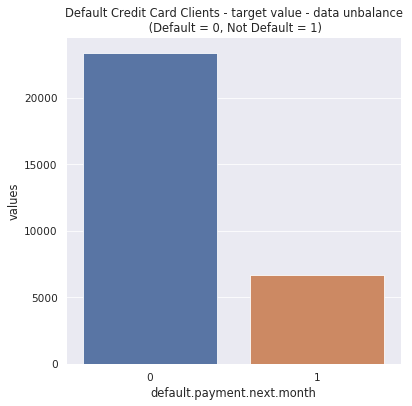

In [4]:
temp = data_df["default.payment.next.month"].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

# prediction

In [40]:
target = 'default.payment.next.month'
predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [41]:
VALID_SIZE = 0.20
RANDOM_STATE = 38
train_df, val_df = train_test_split(data_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [42]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

In [43]:
val_df.to_csv("val_df.csv", index=False)

In [ ]:
# XGboost

In [44]:
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [45]:
model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=50, 
                maximize=True, 
                verbose_eval=50)

[0]	train-auc:0.692664	valid-auc:0.695329
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.768241	valid-auc:0.776386
[100]	train-auc:0.776358	valid-auc:0.78254
[150]	train-auc:0.782007	valid-auc:0.78643
[200]	train-auc:0.785795	valid-auc:0.78845
[250]	train-auc:0.788492	valid-auc:0.789603
[300]	train-auc:0.790844	valid-auc:0.790128
[350]	train-auc:0.792902	valid-auc:0.790322
[400]	train-auc:0.794731	valid-auc:0.79048
[450]	train-auc:0.796923	valid-auc:0.790852
[500]	train-auc:0.79849	valid-auc:0.79065
Stopping. Best iteration:
[454]	train-auc:0.79708	valid-auc:0.790909



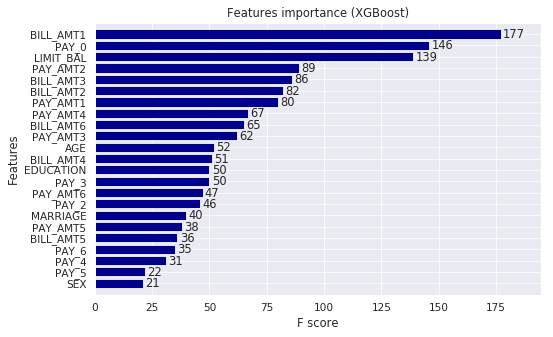

In [46]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="darkblue")
plt.savefig("./plot/feature_importance.png", dpi=500)
plt.show()

In [47]:
# save model
pickle.dump(model, open("model.pkl", "wb"))

# Testing

In [7]:
# load model
model = pickle.load(open("model.pkl","rb"))

# load dataset
val_df = pd.read_csv("val_df.csv")

# define useful column
target = 'default.payment.next.month'
predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [5]:
inpu_id = 4364
test_row = val_df.loc[lambda val_df: val_df.ID==inpu_id, :]
test_row

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,4364,50000.0,2,2,2,27,-1,-1,-2,-2,...,0.0,1075.0,4249.0,0.0,0.0,0.0,1075.0,4307.0,0.0,0


In [8]:
dvalid = xgb.DMatrix(test_row[predictors], test_row[target].values)

In [9]:
output = model.predict(dvalid)[0]
output

0.2013579

In [10]:
val_df["ID"]

0        4364
1        6621
2        2391
3        8066
4       23753
5       26437
6       24590
7       26872
8       17821
9        1545
10      22673
11      18235
12       5654
13       2415
14      24751
15       4352
16      10007
17      17102
18      24722
19       1322
20      12919
21       3066
22      15753
23       1400
24      12389
25      15129
26       6486
27       9400
28       2540
29      25548
        ...  
5970    19818
5971    18211
5972    13996
5973    24134
5974     2878
5975    24763
5976    11284
5977    15164
5978    29909
5979    18260
5980     7888
5981     8029
5982    15148
5983     7653
5984    26581
5985    16089
5986     4885
5987    12503
5988    27799
5989    15158
5990    19576
5991    27023
5992    14586
5993    14679
5994    25610
5995    26027
5996     3042
5997    12600
5998    24718
5999    20886
Name: ID, Length: 6000, dtype: int64

In [12]:
from tabulate import tabulate

In [18]:
test_row.T

,0
ID,4364.0
LIMIT_BAL,50000.0
SEX,2.0
EDUCATION,2.0
MARRIAGE,2.0
AGE,27.0
PAY_0,-1.0
PAY_2,-1.0
PAY_3,-2.0
PAY_4,-2.0


In [19]:
print(tabulate(test_row.T, headers='keys'))

                                0
--------------------------  -----
ID                           4364
LIMIT_BAL                   50000
SEX                             2
EDUCATION                       2
MARRIAGE                        2
AGE                            27
PAY_0                          -1
PAY_2                          -1
PAY_3                          -2
PAY_4                          -2
PAY_5                          -2
PAY_6                          -1
BILL_AMT1                    1500
BILL_AMT2                       0
BILL_AMT3                       0
BILL_AMT4                       0
BILL_AMT5                    1075
BILL_AMT6                    4249
PAY_AMT1                        0
PAY_AMT2                        0
PAY_AMT3                        0
PAY_AMT4                     1075
PAY_AMT5                     4307
PAY_AMT6                        0
default.payment.next.month      0
